# Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

<img src="../images/galaxy_vs_quasar_1.png" alt="Description" width="1000" />

<img src="../images/galaxy_vs_quasar_2.png" alt="Description" width="1000" />

SDSS observed in four bands:

<img src="../images/galaxy_vs_quasar_3.png" alt="Description" width="600" />

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [1]:
import numpy as np
import pylab as plt
import warnings
warnings.filterwarnings("ignore")


data=np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')
#data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

In [2]:
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [3]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

In [4]:
d = dict(zip(names, data.T))
d

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238])}

In [5]:
lab=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
lab

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [6]:
set(lab)

{'GALAXY', 'QSO'}

In [7]:
# Build colors

for diff in ['ug', 'gr', 'ri', 'iz']:
    d[diff]=d[diff[0]]-d[diff[1]] 
d['lab']=lab

In [8]:
d.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'z1', 'ug', 'gr', 'ri', 'iz', 'lab'])

# Quick exploration

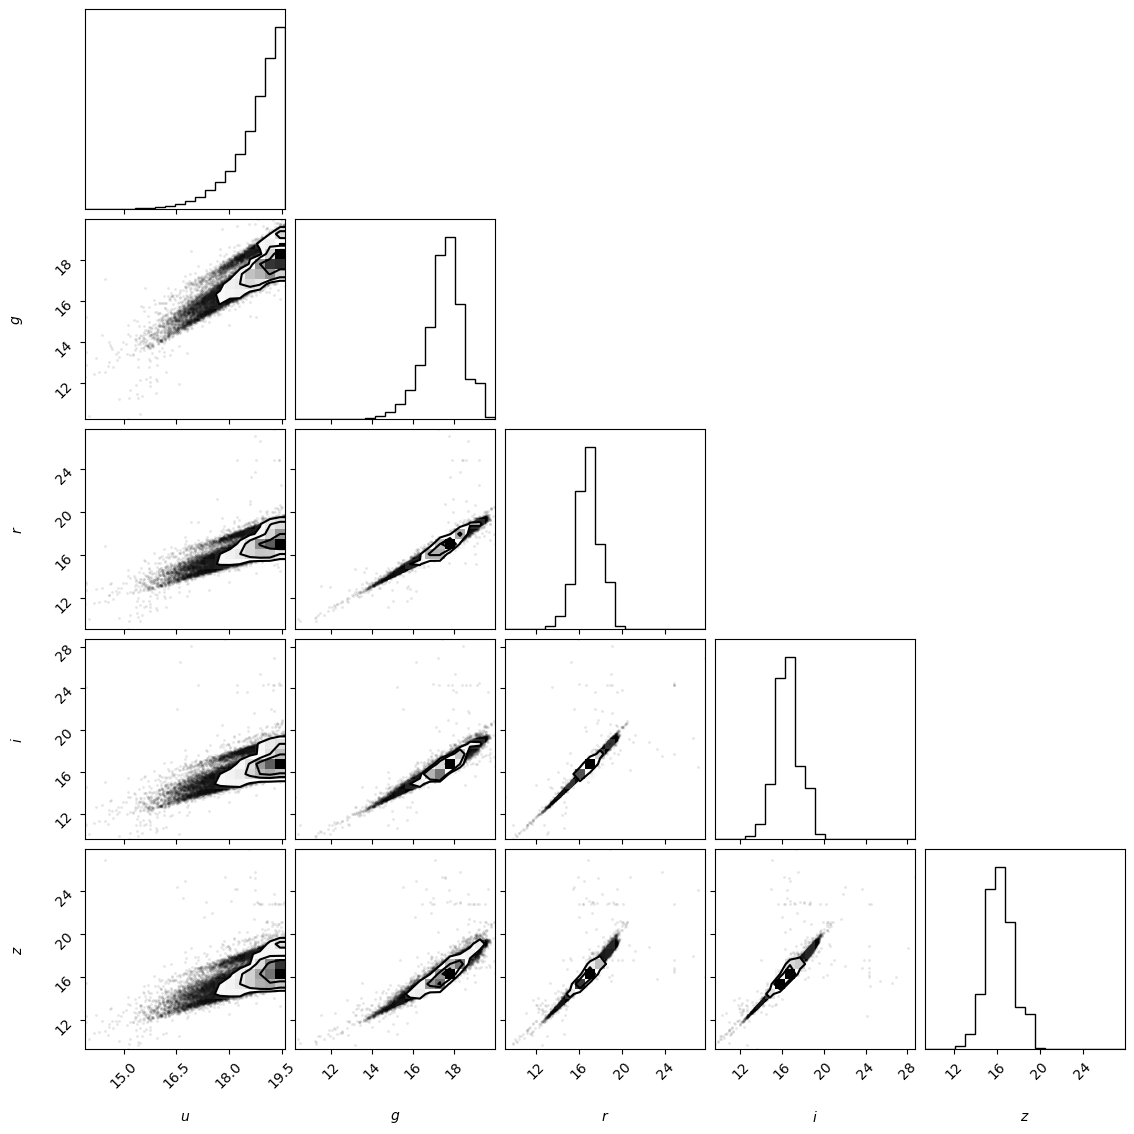

In [9]:
import corner
corner.corner(np.array([d['u'],d['g'],d['r'],d['i'],d['z']]).T, labels=['$u$', '$g$', '$r$', '$i$', '$z$']);

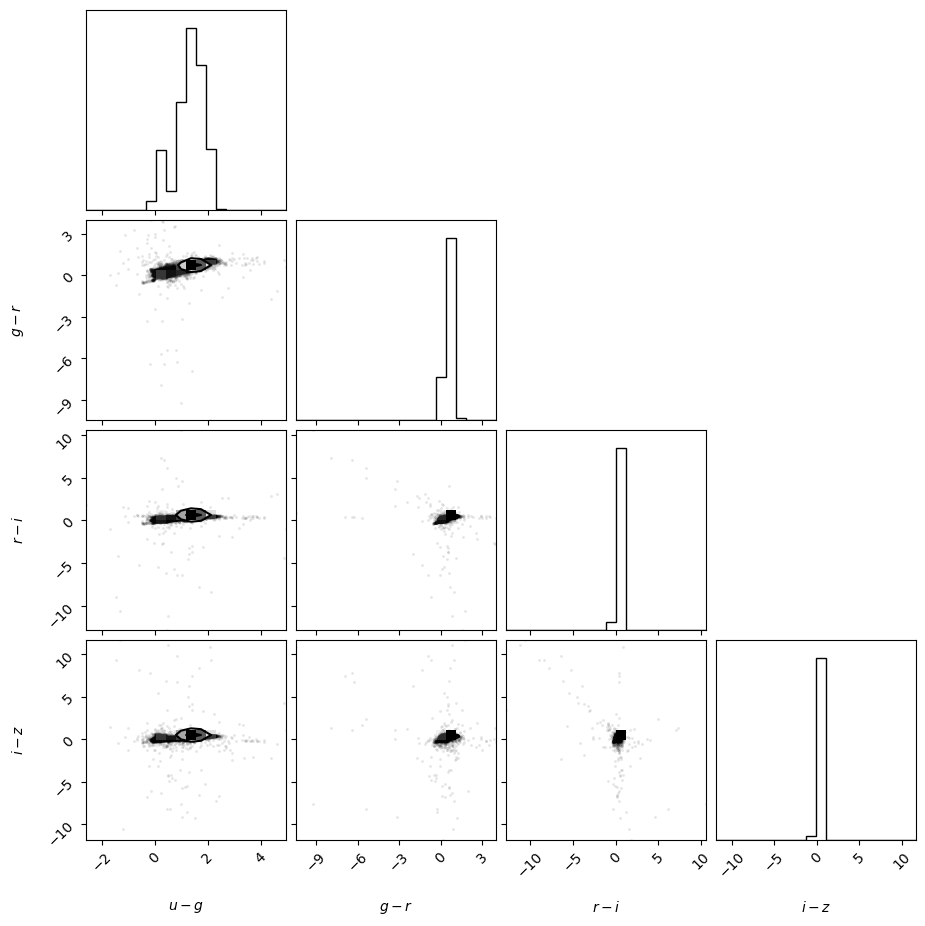

In [10]:
corner.corner(np.array([d['ug'],d['gr'],d['ri'],d['iz']]).T, labels=['$u-g$', '$g-r$', '$r-i$', '$i-z$']);

### We see a bimodality in the u - g color

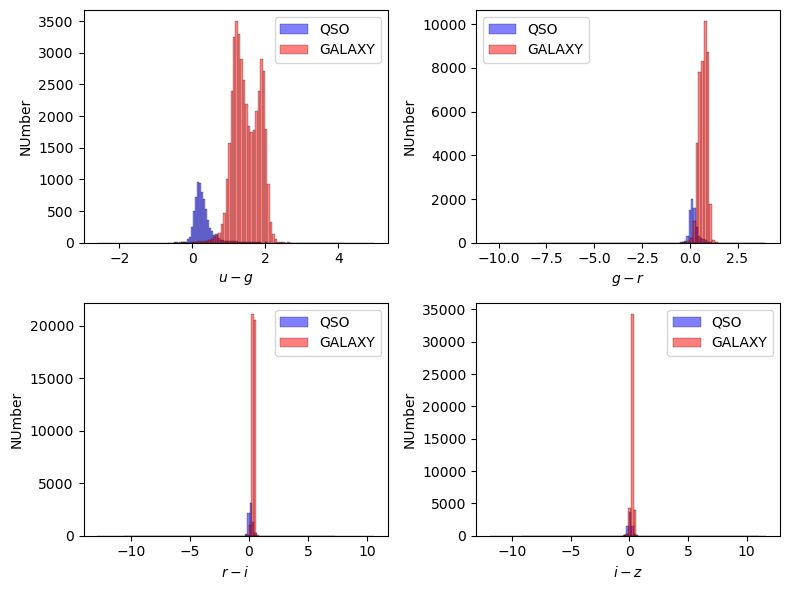

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for ax, color in zip(axs.flatten(), ['ug', 'gr', 'ri', 'iz']):
    # Plot for QSO
    sns.histplot(d[color][lab == 'QSO'],bins=100,color='blue',alpha=0.5,label='QSO',ax=ax)
    
    # Plot for GALAXY
    sns.histplot(d[color][lab == 'GALAXY'],bins=100,color='red',alpha=0.5,label='GALAXY',ax=ax)
    
    ax.set_xlabel(f'${color[0]}-{color[1]}$')
    ax.set_ylabel('NUmber')
    ax.legend()

plt.tight_layout()
plt.show()


## Machine learning

In [12]:
X=np.array([d['ug'], d['gr'], d['ri'], d['iz']]).T
y = np.array(lab=='QSO',dtype=int)

In [13]:
import sklearn.model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=67)

In [15]:
X_train.shape

(33500, 4)

### Gaussian naive bayes 

***Training Phase***

Given a labeled dataset with continuous features and classes:
$$
\{(X^{(1)}, C^{(1)}), (X^{(2)}, C^{(2)}), \ldots, (X^{(N)}, C^{(N)})\}
$$

where $X^{(j)} = (x^{(j)}_1, x^{(j)}_2, \ldots, x^{(j)}_n)$ is the feature vector and $C^{(j)}$ is the class label.

For each class $C_k$:
- **Estimate the prior probability**:
  $$
  P(C_k) = \frac{\text{Number of samples in } C_k}{\text{Total number of samples}}
  $$
- **Estimate the mean and variance of each feature**:
  $$
  \mu_{k,i} = \frac{1}{N_k} \sum_{j \in C_k} x^{(j)}_i
  $$
  $$
  \sigma^2_{k,i} = \frac{1}{N_k} \sum_{j \in C_k} \left(x^{(j)}_i - \mu_{k,i}\right)^2
  $$

where $N_k$ is the number of samples in class $C_k$.

---

***Prediction Phase***

Given a new, unlabeled example $X = (x_1, x_2, \ldots, x_n)$:
- For each class $C_k$:
  - Calculate the **likelihood** of $X$ given $C_k$ using the Gaussian formula:
    $$
    P(X \mid C_k) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma_{k,i}^2}} \exp \left( -\frac{(x_i - \mu_{k,i})^2}{2\sigma_{k,i}^2} \right)
    $$
  - Multiply by the **prior**:
    $$
    P(C_k) \cdot P(X \mid C_k)
    $$

- Select the class with the highest posterior probability:
  $$
  \hat{C} = \arg\max_{C_k} \left[ P(C_k) \cdot P(X \mid C_k) \right]
  $$

In Gaussian Naive Bayes, if you assume equal variances across classes, then the decision boundary is a hyperplane.

If the variances differ between classes, then the decision boundary is a quadratic hypersurface.

In [105]:
print(X_train[y_train==0].shape)
print(X_train[y_train==1].shape)

(28687, 4)
(4813, 4)


In [106]:
print(X_train[y_train==0,0])

[1.50452 1.2846  1.11076 ... 1.25841 1.36609 0.4885 ]


In [107]:
def log_likelihood(X, k, mean, std):
    """
    Compute the log-likelihood(s) for input(s) X given class k.

    Parameters:
    - X: numpy array, shape (n_samples, n_features) 
    - k: class index
    - mean: numpy array, shape (n_classes, n_features)
    - std: numpy array, shape (n_classes, n_features)

    Returns:
    - log_prob: numpy array of shape (n_samples,) or a scalar
    """
    n_features = X.shape[1]
    
    constant = -0.5 * np.sum(np.log(2 * np.pi * (std[k] ** 2)))
    
    quadratic = -0.5 * np.sum(((X - mean[k]) ** 2) / (std[k] ** 2), axis=1)
    
    log_prob = constant + quadratic

    return log_prob

In [61]:

feature_dict = {
    'ug': 0,
    'gr': 1,
    'ri': 2,
    'iz': 3
}

mean = [[] for _ in np.unique(y_train)]
std = [[] for _ in np.unique(y_train)]

# Loop over classes
for k in np.unique(y_train):
    # Loop over features by their index
    for i in range(X_train.shape[1]):
        mean[k].append(np.mean(X_train[y_train == k, i]))
        std[k].append(np.std(X_train[y_train == k, i]))

mean = np.array(mean)
std = np.array(std)

print(mean)
print(std)


[[1.47832387 0.70324899 0.37678248 0.25682265]
 [0.2991899  0.19563024 0.14107093 0.07649158]]
[[0.36403824 0.24889606 0.17094623 0.26800591]
 [0.32163589 0.23937753 0.20184805 0.18799656]]


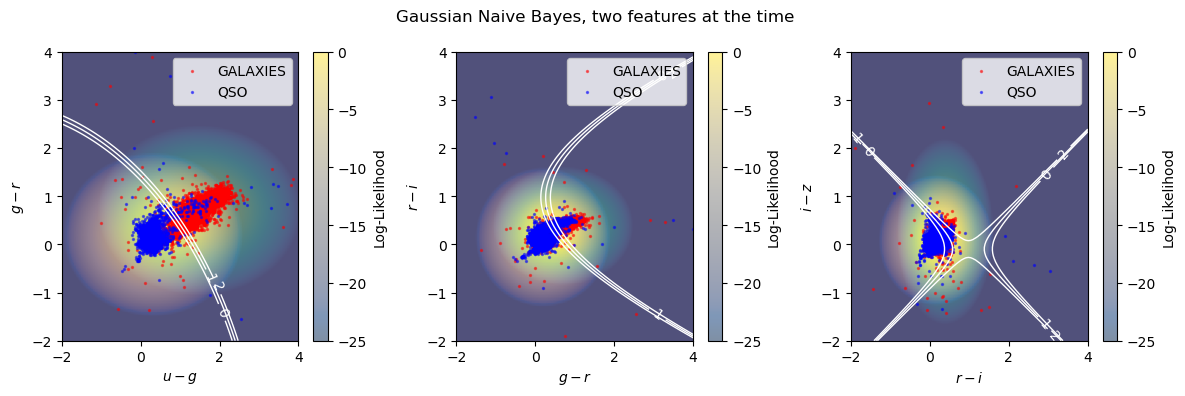

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Gaussian Naive Bayes, two features at the time')

# generic features
feature_1 = np.linspace(-2, 4, 100)
feature_2 = np.linspace(-2, 4, 100)

xx, yy = np.meshgrid(feature_1,feature_2) 

for h,selected_features in enumerate([['ug', 'gr'],['gr', 'ri'],['ri', 'iz']]): # Select features by names

    log_prob_0 = np.zeros_like(xx)
    log_prob_1 = np.zeros_like(xx)

    selected_indices = [feature_dict[feat] for feat in selected_features]
    
    mean_ = mean[:, selected_indices]
    std_ = std[:, selected_indices]
    
    for j in range(xx.shape[0]):
        for i in range(xx.shape[1]):
            point = np.array([[xx[i, j], yy[i, j]]])
            log_prob_0[i, j] = log_likelihood(point, 0, mean_, std_)
            log_prob_1[i, j] = log_likelihood(point, 1, mean_, std_)
    
    # Difference of log-probabilities (class 1 minus class 0)
    delta_log_prob = log_prob_0 - log_prob_1
    
    im = ax[h].imshow(log_prob_0,extent=[-2, 4, -2, 4],origin='lower',cmap='viridis',aspect='auto',vmax=0,vmin=-25,alpha=0.5)
    im = ax[h].imshow(log_prob_1,extent=[-2, 4, -2, 4],origin='lower',cmap='cividis',aspect='auto',vmax=0,vmin=-25,alpha=0.5)
    plt.colorbar(ax=ax[h], mappable=im, label='Log-Likelihood')
    ax[h].set_xlabel(f'${selected_features[0][0]}-{selected_features[0][1]}$')
    ax[h].set_ylabel(f'${selected_features[1][0]}-{selected_features[1][1]}$')

    # Scatter plot
    ax[h].scatter(X_test[y_test==0,selected_indices[0]], X_test[y_test==0,selected_indices[1]], c='r', s=2, alpha=0.5, label='GALAXIES')
    ax[h].scatter(X_test[y_test==1,selected_indices[0]], X_test[y_test==1,selected_indices[1]], c='b', s=2, alpha=0.5, label='QSO')
    ax[h].set_xlim(-2,4)
    ax[h].set_ylim(-2,4)
    
    # Add decision boundary (where delta_log_prob == 0)
    cs = ax[k].contour(
        xx, yy, delta_log_prob,
        levels=[0,1,2],
        colors='white',
        linewidths=1
    )
    ax[k].clabel(cs, colors='white')
    
    ax[k].legend()

plt.tight_layout()
plt.show()

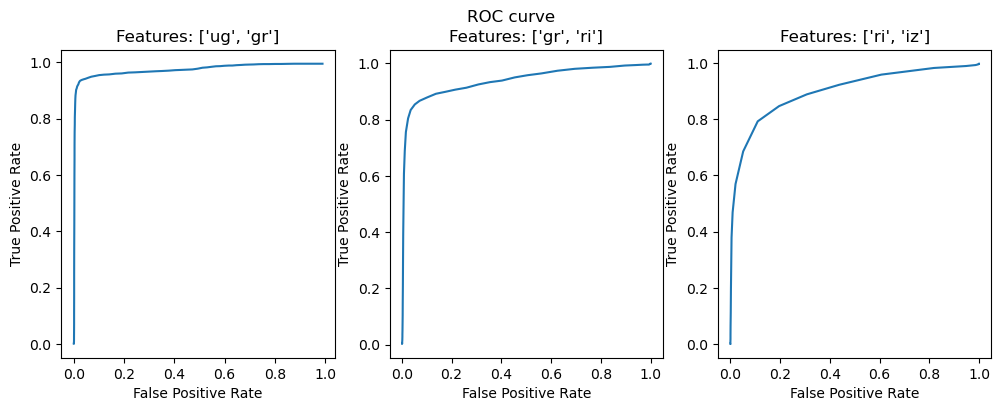

In [148]:
# Build ROC curves in the three cases
fig,ax = plt.subplots(1, 3, figsize=(12, 4)) 
fig.suptitle('ROC curve')

for h,selected_features in enumerate([['ug', 'gr'],['gr', 'ri'],['ri', 'iz']]): # Select features by names

    selected_indices = [feature_dict[feat] for feat in selected_features]
    
    mean_ = mean[:, selected_indices]
    std_ = std[:, selected_indices]

    X_test_pos = X_test[y_test == 1][:, selected_indices]
    X_test_neg = X_test[y_test == 0][:, selected_indices]

    # Calculate log-likelihoods for all samples and both classes
    log_prob_pos_0 = log_likelihood(X_test_pos, 0, mean_, std_)
    log_prob_pos_1 = log_likelihood(X_test_pos, 1, mean_, std_)
    log_diff_pos = log_prob_pos_0 - log_prob_pos_1

    log_prob_neg_0 = log_likelihood(X_test_neg, 0, mean_, std_)
    log_prob_neg_1 = log_likelihood(X_test_neg, 1, mean_, std_)
    log_diff_neg = log_prob_neg_0 - log_prob_neg_1

    # Concatenate thresholds
    thresholds = np.linspace(-20, 20, 100)
    true_positive_rate = []
    false_positive_rate = []

    for threshold in thresholds:
        tp = np.sum(log_diff_pos < threshold)
        fp = np.sum(log_diff_neg < threshold)
        tpr = tp / len(log_diff_pos)
        fpr = fp / len(log_diff_neg)
        true_positive_rate.append(tpr)
        false_positive_rate.append(fpr)
    
    ax[h].plot(false_positive_rate, true_positive_rate)
    ax[h].set_title(f"Features: {selected_features}")
    ax[h].set_xlabel("False Positive Rate")
    ax[h].set_ylabel("True Positive Rate")

plt.show()



# Linear Discriminant Analysis (LDA)

LDA assumes that:

- Each class has a multivariate normal distribution.
- The covariance matrix is the same across all classes.

Given:

- $X$ with shape ($n_\text{samples},n_\text{features})$
- Class index $k$
- Class mean vector $\mu_k$​
- Shared covariance matrix $\Sigma$

The log-likelihood for each sample is:
$$
\log p(\mathbf{x} \mid y = k) = -\frac{1}{2} \left[ (\mathbf{x} - \boldsymbol{\mu}_k)^\top \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) + \log |\Sigma| + d \log (2\pi) \right]
$$
Expanding the quadratic term:
$$
(X - \mu_k)^T \Sigma^{-1} (X - \mu_k) = X^T \Sigma^{-1} X - 2 \mu_k^T \Sigma^{-1} X + \mu_k^T \Sigma^{-1} \mu_k
$$

- The term $X^T \Sigma^{-1} X$ is **independent of class**, so it **cancels out** when comparing classes.
- The remaining terms are **linear in $X$** plus some class-dependent constants.

Hence, the **decision boundaries** are linear hyperplanes.


In [149]:
print(mean)

[[1.47832387 0.70324899 0.37678248 0.25682265]
 [0.2991899  0.19563024 0.14107093 0.07649158]]


For **LDA**, you need the **mean vector of each class**:

$$
\boldsymbol{\mu}_k = \frac{1}{N_k} \sum_{i: y_i = k} \mathbf{x}_i
$$

where:

- \( N_k \) is the number of samples in class \( k \).
- \( \mathbf{x}_i \) is the feature vector of sample \( i \).

Unlike Gaussian Naive Bayes, **LDA** shares a single covariance matrix across all classes:

$$
\Sigma = \frac{1}{N - K} \sum_{k} \sum_{i: y_i = k} (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^\top
$$

where:

- \( N \) is the total number of samples.
- \( K \) is the number of classes (for binary classification, \( K = 2 \)).

This captures **feature correlations** across all classes.

In [150]:
print(mean)

[[1.47832387 0.70324899 0.37678248 0.25682265]
 [0.2991899  0.19563024 0.14107093 0.07649158]]


In [151]:
# Compute shared covariance matrix
cov = np.zeros((4, 4))
for k in [0,1]:   # loop over classes
    X_k = X_train[y_train == k]
    diff = X_k - mean[k]
    cov += diff.T @ diff
cov /= (len(X_train) - 2)


In [152]:
print(cov)

[[ 0.12835436  0.06255207  0.022046    0.02461983]
 [ 0.06255207  0.06128517  0.013403    0.01122713]
 [ 0.022046    0.013403    0.03087956 -0.01063574]
 [ 0.02461983  0.01122713 -0.01063574  0.06658936]]


In [153]:
def log_likelihood_LDA(X, k, mean, cov_inv):
    """
    Compute the log-likelihood(s) for input(s) X given class k, using LDA.

    Parameters:
    - X: numpy array, shape (n_samples, n_features)
    - k: class index
    - mean: numpy array, shape (n_classes, n_features)
    - cov: numpy array, shape (n_features, n_features) — shared covariance matrix

    Returns:
    - log_prob: numpy array of shape (n_samples,)
    """
    mu_k = mean[k]  # shape (n_features,)
    
    # Linear term: X @ cov_inv @ mu_k
    linear_term = X @ cov_inv @ mu_k
    
    # Quadratic term: -0.5 * mu_k.T @ cov_inv @ mu_k
    quadratic_term = -0.5 * (mu_k.T @ cov_inv @ mu_k)
    
    # The constant term is omitted (since it’s the same across classes for decision-making)
    log_prob = linear_term + quadratic_term
    
    return log_prob


In [154]:
log_likelihood_diff = log_likelihood_LDA(X_test, 0, mean, cov) - log_likelihood_LDA(X_test, 1, mean, cov)

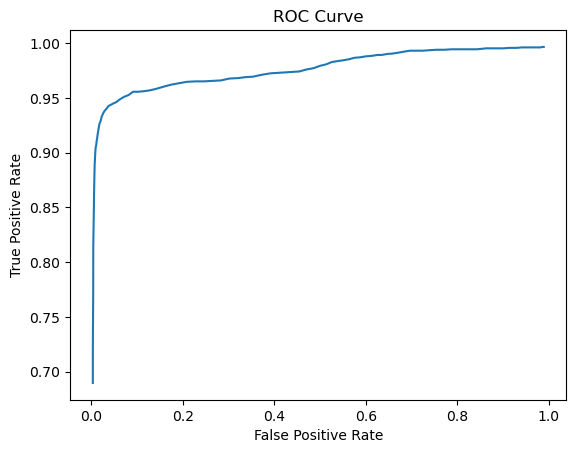

In [155]:
thresholds = np.linspace(np.quantile(log_likelihood_diff,0.1), np.quantile(log_likelihood_diff,0.99), 100)

true_positive_rate = []
false_positive_rate = []

# count total positives and negatives once
total_positives = np.sum(y_test == 1)
total_negatives = np.sum(y_test == 0)

for t in thresholds:
    y_pred = (log_likelihood_diff < t).astype(int)  # classify as 1 if diff < t
    
    true_positive = np.sum((y_pred == 1) & (y_test == 1))
    false_positive = np.sum((y_pred == 1) & (y_test == 0))
    
    tpr = true_positive / total_positives
    fpr = false_positive / total_negatives
    
    true_positive_rate.append(tpr)
    false_positive_rate.append(fpr)

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [71]:
# Using scklearn

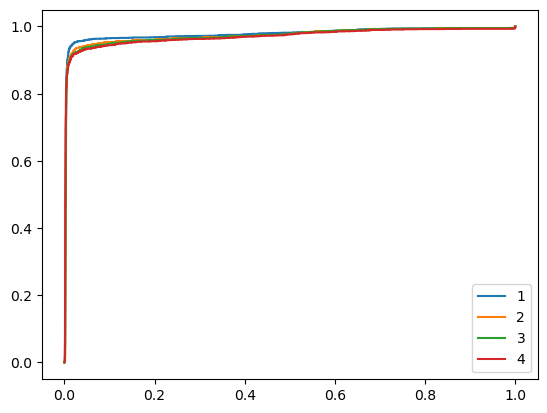

In [157]:
clf = GaussianNB()

for i in range(4):

    clf.fit(X_train[:,0:i+1] ,y_train )

    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
plt.legend()


(33500, 1)
(33500, 2)
(33500, 3)
(33500, 4)


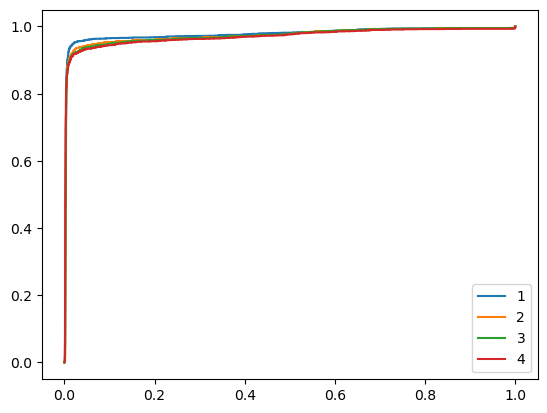

In [156]:
cfl = QuadraticDiscriminantAnalysis()

for i in range(4):

    print( X_train[:,0:i+1].shape )
    clf.fit(X_train[:,0:i+1] ,y_train )
    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
    
plt.legend()

(0.9, 1.0)

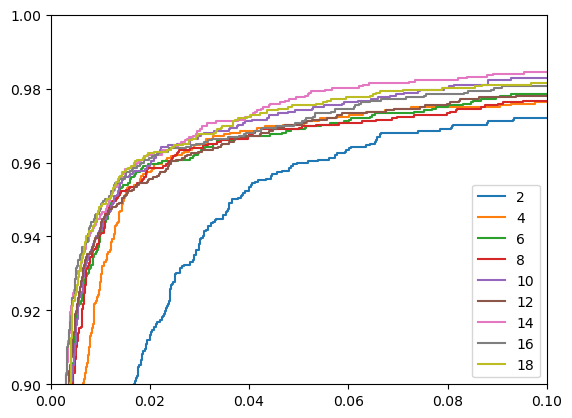

In [158]:
for n in np.arange(2,20)[::2]:
    
    clf = GMMBayes(n_components=n)
    clf.fit(X_train[:,0:4],y_train)
    
    y_prob = clf.predict_proba(X_test[:,0:4]) [:,1] 
        
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(n))

plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)

(0.9, 1.0)

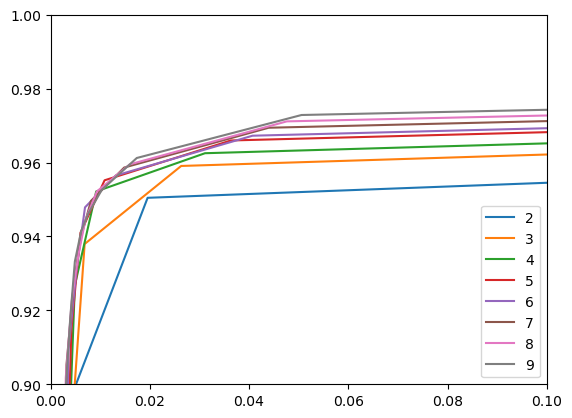

In [159]:
for n in np.arange(2,10):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train[:,0:4],y_train)
    
    y_prob = clf.predict_proba(X_test[:,0:4]) [:,1] 
        
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(n))

plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)